In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import pickle
import matplotlib.pyplot as plt

In [2]:
print(torch.cuda.device_count())
print(torch.cuda.is_available())
print(torch.version.cuda)

1
True
11.8


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
import random

#Set seed
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [5]:
# 데이터 로드 및 전처리 함수
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path, header=None)
    data = df.values
    return data

# 다중 타임 스텝 데이터를 생성하는 함수
def create_multistep_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :-1])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)

[[ 0.36328772  0.35860745  0.34462677  0.        ]
 [-8.28879996 -8.34585117 -9.41534225  0.        ]
 [-8.32494661 -8.5007654  -9.38263813  0.        ]
 ...
 [-0.03631257  0.18236954  1.70138119  0.        ]
 [-0.06132232  0.19537461  1.67837222  0.        ]
 [-0.05832115  0.23238905  1.68337417  0.        ]]


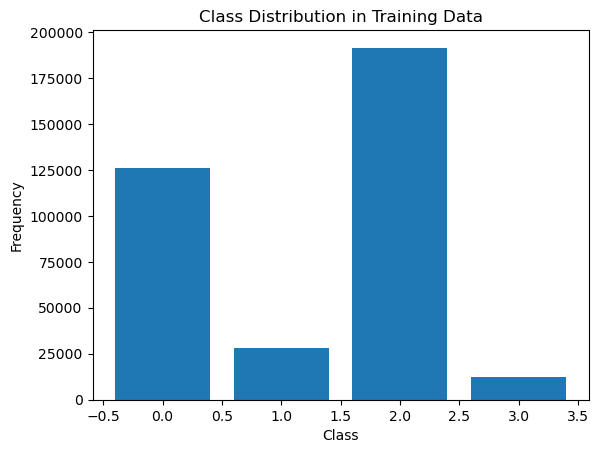

(357734, 3)


In [6]:
# 모든 학습 데이터 로드 및 병합
all_data = []

file_paths = [f"C:\\Users\\jy\\Desktop\\code\\ReLabeling\\labeled\\Denormalize\\F{i}_combined.csv" for i in range(1, 50)]
for file_path in file_paths:
    data = load_and_preprocess(file_path)
    all_data.append(data)

all_data = np.vstack(all_data)

print(all_data)

# 데이터 분포 확인
plt.hist(all_data[:, 3], bins=range(5), align='left', rwidth=0.8)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Data')
plt.show()

print(all_data[:, :3].shape)

In [7]:
# 다중 타임 스텝 데이터 생성
time_steps = 10  # 예시로 3개의 타임 스텝을 고려
X, y = create_multistep_data(all_data, time_steps)
y = y.astype(int)

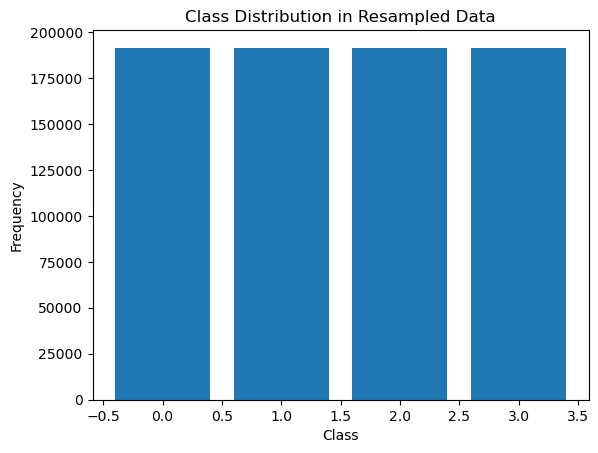

In [8]:
# 데이터 증강 (SMOTE)
smote = SMOTE()
X_reshaped = X.reshape(X.shape[0], -1)  # SMOTE를 적용하기 위해 2D 형태로 변환
X_res, y_res = smote.fit_resample(X_reshaped, y)
X_res = X_res.reshape(X_res.shape[0], time_steps, X.shape[2])  # 다시 3D 형태로 변환

# 증강된 데이터의 클래스 분포 확인
plt.hist(y_res, bins=range(5), align='left', rwidth=0.8)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Resampled Data')
plt.show()

In [9]:
batch_size = 128

# PyTorch 데이터셋 및 데이터로더 생성
X_tensor = torch.tensor(X_res, dtype=torch.float32)
y_tensor = torch.tensor(y_res, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, device=device):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model, device=device)
        position = torch.arange(0, max_len, dtype=torch.float, device=device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)).to(device)
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1)]


class TransformerModel(nn.Module):
    def __init__(self, input_size, num_classes, d_model=128, nhead=8, num_encoder_layers=3, dim_feedforward=256,
                 dropout=0.01, device=torch.device('cpu')):
        super(TransformerModel, self).__init__()
        self.input_size = input_size
        self.d_model = d_model
        # 입력 데이터를 d_model 차원으로 변환
        self.embedding = nn.Linear(input_size, d_model)
        # self.relu1 = nn.ReLU()  # 첫 번째 ReLU 활성화 함수 추가
        self.pos_encoder = PositionalEncoding(d_model, device=device)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.fc_out = nn.Linear(d_model, num_classes)
        # self.relu2 = nn.ReLU()  # 출력 전 ReLU 활성화 함수 추가

    def forward(self, src):
        #print(f"Original src shape: {src.shape}")
        src = self.embedding(src) * math.sqrt(self.d_model)
        #print(f"After embedding shape: {src.shape}")
        # src = self.relu1(src)  # 첫 번째 ReLU 적용
        src = self.pos_encoder(src)
        #print(f"After positional encoding shape: {src.shape}")
        output = self.transformer_encoder(src)
        #print(f"After transformer encoder shape: {output.shape}")
        output = output.mean(dim=1)  # 평균 풀링
        #print(f"After mean pooling shape: {output.shape}")
        output = self.fc_out(output)
        #print(f"After final linear layer shape: {output.shape}")
        # output = self.relu2(output)  # 출력 전 ReLU 적용
        return output

input_size = X_res.shape[2]
print(f'input_size: {input_size}')  # input_size 확인
# hidden_size = 128
# output_size = 4
# num_heads = 8  # num_heads가 input_size로 나누어 떨어지도록 설정

input_size = 3  # Force x, y, z
num_classes = 4  # Number of labels
num_epochs = 20

# input_size가 num_heads로 나누어 떨어지지 않는 경우 오류 발생
# assert input_size % num_heads == 0, "input_size must be divisible by num_heads"

model = TransformerModel(input_size, num_classes, device=device).to(device)


# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

input_size: 3


In [11]:
import torch.nn.functional as F

def custom_loss(outputs, labels):
    softmax_outputs = F.log_softmax(outputs, dim=1)
    return F.nll_loss(softmax_outputs, labels)

In [12]:
model

TransformerModel(
  (embedding): Linear(in_features=3, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.01, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.01, inplace=False)
        (dropout2): Dropout(p=0.01, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=128, out_features=4, bias=True)
)

In [13]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): Loss가 개선되지 않는 epoch 수
            min_delta (float): 이전 Loss 대비 개선된 것으로 인정할 최소 감소량
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# 학습 루프에 조기 중단 로직 적용
early_stopping = EarlyStopping(patience=5, min_delta=0.1)

In [14]:
num_epochs = 50

# 모델 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_accuracy, train_losses, val_losses, val_accuracy = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # print(X_batch.shape)
            # raise 1000
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == y_batch).sum().item()
        
        train_accuracy.append(train_correct / len(train_dataset))
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracy.append(correct / len(val_dataset))
        print(f'Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_correct / len(train_dataset):.4f}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {correct / len(val_dataset):.4f}')
    
    return train_accuracy, train_losses, val_losses, val_accuracy

# 모델 학습
train_accuracy, train_losses, val_losses, val_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Epoch 1/50, Train Accuracy: 0.4826, Train Loss: 1.1043, Val Loss: 1.0829, Val Accuracy: 0.5018
Epoch 2/50, Train Accuracy: 0.5148, Train Loss: 1.0573, Val Loss: 1.0499, Val Accuracy: 0.5217
Epoch 3/50, Train Accuracy: 0.5242, Train Loss: 1.0399, Val Loss: 1.0245, Val Accuracy: 0.5361
Epoch 4/50, Train Accuracy: 0.5319, Train Loss: 1.0249, Val Loss: 0.9978, Val Accuracy: 0.5467
Epoch 5/50, Train Accuracy: 0.5160, Train Loss: 1.0538, Val Loss: 1.0488, Val Accuracy: 0.5208
Epoch 6/50, Train Accuracy: 0.5092, Train Loss: 1.0633, Val Loss: 1.0587, Val Accuracy: 0.5105
Epoch 7/50, Train Accuracy: 0.5238, Train Loss: 1.0364, Val Loss: 1.0028, Val Accuracy: 0.5416
Epoch 8/50, Train Accuracy: 0.5338, Train Loss: 1.0179, Val Loss: 0.9887, Val Accuracy: 0.5483
Epoch 9/50, Train Accuracy: 0.3605, Train Loss: nan, Val Loss: nan, Val Accuracy: 0.2504
Epoch 10/50, Train Accuracy: 0.2499, Train Loss: nan, Val Loss: nan, Val Accuracy: 0.2504
Epoch 11/50, Train Accuracy: 0.2499, Train Loss: nan, Val Los

KeyboardInterrupt: 

In [ ]:
# import matplotlib.pyplot as plt

# num_epochs=10

# # 학습 및 검증 손실과 정확도를 저장할 리스트
# train_losses = []
# val_losses = []
# train_accuracies = []
# val_accuracies = []

# def train_epoch(model, data_loader, criterion, optimizer, device):
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     for batch in data_loader:
#         inputs, labels = batch[:2]
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         outputs = model(inputs)
#         print(f"train outputs:{outputs}")
#         loss = criterion(outputs, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     avg_loss = running_loss / len(data_loader)
#     accuracy = correct / total
#     return avg_loss, accuracy

# def e_model(model, data_loader, criterion, device):
#     model.eval()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for batch in data_loader:
#             inputs, labels = batch[:2]
#             inputs = inputs.to(device)
#             labels = labels.to(device)
#             outputs = model(inputs)
#             print(f"val outputs:{outputs}")
#             loss = criterion(outputs, labels)

#             running_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     avg_loss = running_loss / len(data_loader)
#     accuracy = correct / total
#     return avg_loss, accuracy

# # 학습 루프
# for epoch in range(num_epochs):
#     #scheduler.step()
#     train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
#     val_loss, val_accuracy = e_model(model, val_loader, criterion, device)

#     if early_stopping(val_loss):
#         print(f"Early stopping at epoch {epoch+1}")
#         break

#     train_losses.append(train_loss)
#     val_losses.append(val_loss)
#     train_accuracies.append(train_accuracy)
#     val_accuracies.append(val_accuracy)



#     print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

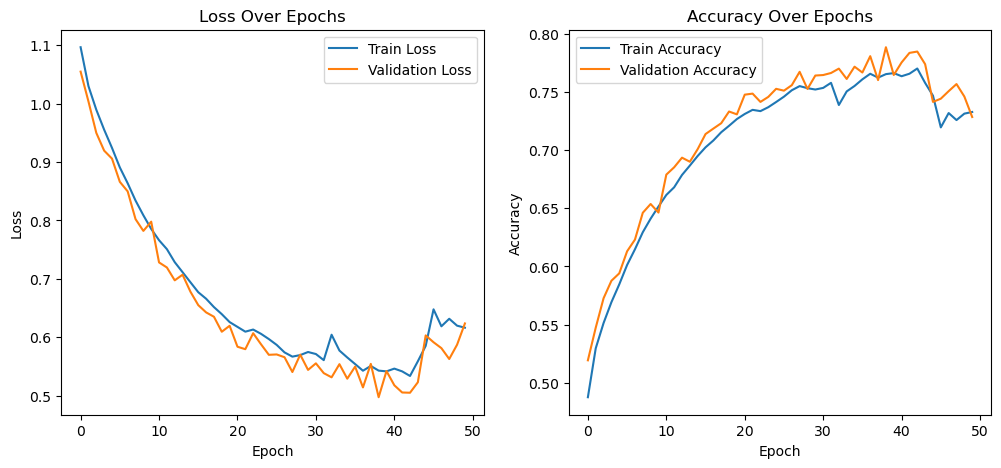

In [ ]:
# 학습 과정의 손실 값과 정확도 출력
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Test Loss: 0.23265764661426566
Test Accuracy: 94.51%
Confusion Matrix:
[[ 3340    45     0    30]
 [  159   449   121    26]
 [   39   101 14808   414]
 [   57    16    85   234]]


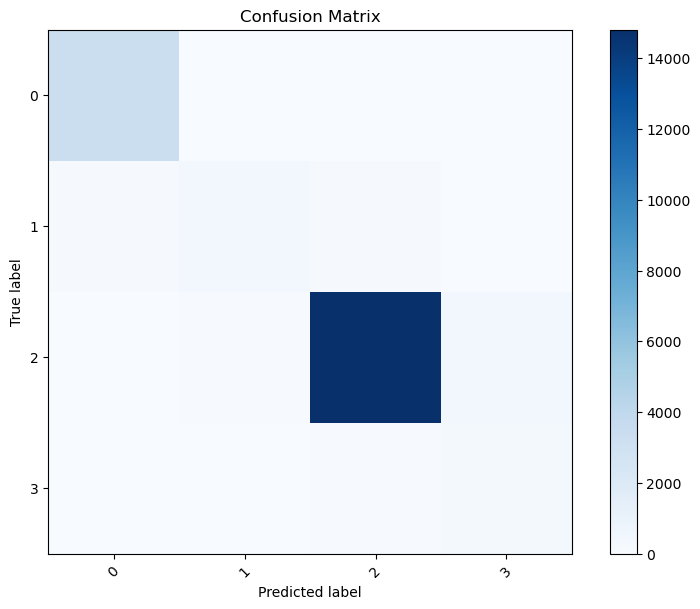

In [ ]:
# 테스트 데이터 로드 및 전처리
test_file_path = "C:\\Users\\jy\\Desktop\\code\\ReLabeling\\labeled\\Denormalize\\F51_combined.csv"
test_data = load_and_preprocess(test_file_path)

# 테스트 데이터도 다중 타임 스텝 데이터로 변환
X_test, y_test = create_multistep_data(test_data, time_steps)
y_test = y_test.astype(int)

# 테스트 데이터 텐서로 변환
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# 모델 평가
model.eval()
test_loss, correct = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_accuracy = correct / len(test_dataset)
conf_matrix = confusion_matrix(y_true, y_pred)
acc_score = accuracy_score(y_true, y_pred)

print(f"Test Loss: {test_loss / len(test_loader)}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, [0, 1, 2, 3], rotation=45)
plt.yticks(tick_marks, [0, 1, 2, 3])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
'''
model_save_path = os.path.join("transformer_model_test.pth")

# 모델 저장
torch.save(model.state_dict(), model_save_path)


def save_model_to_onnx(model, input_size, file_name="transformer_model_test.onnx"):
    model.eval()
    dummy_input = torch.randn(1, time_steps, input_size).to(device)
    torch.onnx.export(model, dummy_input, file_name, 
                      export_params=True,        
                      opset_version=14,          # ONNX 버전
                      do_constant_folding=True,  
                      input_names = ['input'],   
                      output_names = ['output'], 
                      dynamic_axes={'input' : {0 : 'batch_size'},    
                                    'output' : {0 : 'batch_size'}})
    print(f"Model saved as {file_name}")

save_model_to_onnx(model, input_size)
'''

'\nmodel_save_path = os.path.join("transformer_model_test.pth")\n\n# 모델 저장\ntorch.save(model.state_dict(), model_save_path)\n\n\ndef save_model_to_onnx(model, input_size, file_name="transformer_model_test.onnx"):\n    model.eval()\n    dummy_input = torch.randn(1, time_steps, input_size).to(device)\n    torch.onnx.export(model, dummy_input, file_name, \n                      export_params=True,        \n                      opset_version=14,          # ONNX 버전\n                      do_constant_folding=True,  \n                      input_names = [\'input\'],   \n                      output_names = [\'output\'], \n                      dynamic_axes={\'input\' : {0 : \'batch_size\'},    \n                                    \'output\' : {0 : \'batch_size\'}})\n    print(f"Model saved as {file_name}")\n\nsave_model_to_onnx(model, input_size)\n'

In [ ]:
# 모델에 대한 입력값
x = torch.randn(1, 10, 3, requires_grad=True).cuda()
torch_out = model(x)

# 모델 변환
torch.onnx.export(model,               # 실행될 모델
                  x,                         # 모델 입력값 (튜플 또는 여러 입력값들도 가능)
                  "transformer_denorm4.onnx",   # 모델 저장 경로 (파일 또는 파일과 유사한 객체 모두 가능)
                  export_params=True,        # 모델 파일 안에 학습된 모델 가중치를 저장할지의 여부
                  opset_version=14,          # 모델을 변환할 때 사용할 ONNX 버전
                  do_constant_folding=True,  # 최적화시 상수폴딩을 사용할지의 여부
                  input_names = ['input'],   # 모델의 입력값을 가리키는 이름
                  output_names = ['output'], # 모델의 출력값을 가리키는 이름
                  dynamic_axes={'input' : {0 : 'batch_size'},    # 가변적인 길이를 가진 차원
                                'output' : {0 : 'batch_size'}})

In [ ]:
import onnx
from onnx import shape_inference

path = "./transformer_denorm4.onnx"
onnx.save(onnx.shape_inference.infer_shapes(onnx.load(path)), path)

In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("transformer_denorm4.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# ONNX 런타임에서 계산된 결과값
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# ONNX 런타임과 PyTorch에서 연산된 결과값 비교
# np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

# print("Exported model has been tested with ONNXRuntime, and the result looks good!")